In [1]:
%load_ext autoreload
%autoreload 2

import xarray as xr
import numpy as np
from dask.distributed import Client
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import xesmf as xe
from scipy.stats import linregress
import os
import requests
import os
import scipy.signal as sps
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from xgcm import Grid
import seawater
import seaborn as sns


os.chdir('/g/data/xv83/np1383/src_CAFE60_eqpac_analysis_code/')
from C60_obs_functions import convert_trim_fratios
from xarray_trends import xarray_detrend,xarray_get_trend, deseasonaliser
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster

In [2]:
atmos=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/atmos_isobaric_month.zarr.zip')
#atmos['lon']=atmos['lon']+360
eqpac_atmos=atmos.sel(lon=slice(120,290),lat=slice(-40,40))
eqpac_atmos['time']=eqpac_atmos.time.astype('datetime64[M]')
eqpac_atmos=eqpac_atmos.sel(ensemble=25)[['u_ref','v_ref']]
#eqpac_atmos=eqpac_atmos.load()
eqpac_atmos

<xarray.Dataset>
Dimensions:   (time: 731, lat: 40, lon: 68)
Coordinates:
    ensemble  int32 25
  * lat       (lat) float64 -39.44 -37.42 -35.39 -33.37 ... 35.39 37.42 39.44
  * lon       (lon) float64 121.2 123.8 126.2 128.8 ... 281.2 283.8 286.2 288.8
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
Data variables:
    u_ref     (time, lat, lon) float32 dask.array<chunksize=(1, 40, 68), meta=np.ndarray>
    v_ref     (time, lat, lon) float32 dask.array<chunksize=(1, 40, 68), meta=np.ndarray>
Attributes: (12/27)
    NCO:                        netCDF Operators version 4.7.8 (Homepage = ht...
    calendar:                    julian
    cm-enkf_source:             commit 0141830a243704acbf6d8c8c843b161a39ec39fa
    comment:                    pressure level interpolator, version 3.0, pre...
    contact_name:               Decadal Activity 1 - Data Assimilation
    control_name:               c5
    ...                         ...
    model_source:               commit 2abb29f4384e68777721fa657850587f28efd85a
    nominal_resoltuion:         Atmosphere delta lat = 2.02degrees ; Atmosphe...
    perturbation_name:          not applicable
    references:                 OKane, T.J., Sandery, P.A., Monselesan, D.P.,...
    run_variant_name:           data assimilation
    title:                      AccessOcean-AM2

In [3]:
phys=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_month.zarr.zip')
phys=phys.rename({'xu_ocean':'lon_x','yu_ocean':'lat_x'})
phys=phys.rename({'xt_ocean':'lon','yt_ocean':'lat'})
phys['lon']=phys['lon']+360
phys['lon_x']=phys['lon_x']+360
phys_eqpac=phys.sel(lon=slice(120,290),lat=slice(-40,40))
phys_eqpac=phys_eqpac.sel(lon_x=slice(120,290),lat_x=slice(-40,40))
phys_eqpac['time']=phys_eqpac.time.astype('datetime64[M]')
phys_eqpac

,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [4]:
# LOAD CAFE
bgc=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_bgc_month.zarr.zip')
bgc=bgc.rename({'xt_ocean':'lon','yt_ocean':'lat'})
bgc['lon']=bgc['lon']+360
eqpac=bgc.sel(lon=slice(120,290),lat=slice(-40,40))
eqpac['time']=eqpac.time.astype('datetime64[M]')
eqpac

,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [33]:
cluster = SLURMCluster(cores=8,processes=2,memory="47GB")

client = Client(cluster)
cluster.scale(cores=64)
cluster

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39963 instead
  warnings.warn(


In [74]:
cluster#.exit()#.close()

ERROR! Session/line number was not unique in database. History logging moved to new session 2771


In [6]:
# Areas and grid depths

adic=(eqpac.sel(ensemble=25)[['dic','adic']])
area=xr.open_dataset('/g/data/xv83/rxm599/area.nc')
area['xt_ocean']=area['xt_ocean']+360
area['xu_ocean']=area['xu_ocean']+360
area_m2=area.sel(xt_ocean=slice(120,290),yt_ocean=slice(-40,40)).area_t.rename({'xt_ocean':'lon','yt_ocean':'lat'})

st_ocean_holder=adic.st_ocean
l=0
depth_diffs=[]
# Calcualate the m between depths so we can integrate
for i,x in enumerate(st_ocean_holder.st_ocean):
    d=x.values-l
    l=x.values
    #print(d)#x.values)
    depth_diffs.append(d)
    
st_ocean_holder=st_ocean_holder.assign_coords(
    depth_diff=('st_ocean', depth_diffs))

In [8]:
# Calc Canth Accumulation
raw_carbon=adic.sel(time=slice('2000-01-01','2020-01-01'),lat=slice(-5,5)).load() #CHECK LOAD
raw_carbon_area=raw_carbon*area_m2*st_ocean_holder.depth_diff
anth_c_area=raw_carbon_area.adic-raw_carbon_area.dic
raw_anth_c=raw_carbon.adic-raw_carbon.dic
anth_c_area     #mmol m3

<xarray.DataArray (time: 241, st_ocean: 50, lat: 30, lon: 170)>
array([[[[9.97072568e+11, 9.94322678e+11,            nan, ...,
                     nan,            nan,            nan],
         [9.84114790e+11, 9.81388493e+11,            nan, ...,
                     nan,            nan,            nan],
         [9.73511066e+11, 9.71681300e+11,            nan, ...,
                     nan,            nan,            nan],
         ...,
         [9.92249119e+11, 9.96739645e+11, 9.98302024e+11, ...,
                     nan,            nan,            nan],
         [1.00166795e+12, 1.00288954e+12, 1.00146086e+12, ...,
                     nan,            nan,            nan],
         [1.00908138e+12, 1.00824515e+12, 1.00420551e+12, ...,
                     nan,            nan,            nan]],

        [[1.99430242e+12, 1.98874497e+12,            nan, ...,
                     nan,            nan,            nan],
         [1.96841308e+12, 1.96283466e+12,            nan, ...,
                     nan,            nan,            nan],
         [1.94710602e+12, 1.94342552e+12,            nan, ...,
                     nan,            nan,            nan],
...
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan]],

        [[           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         ...,
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan]]]])
Coordinates:
  * lat         (lat) float64 -4.833 -4.5 -4.166 -3.834 ... 4.166 4.5 4.833
    ensemble    int32 25
  * st_ocean    (st_ocean) float64 5.0 15.0 25.0 ... 5.499e+03 5.831e+03
  * time        (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2020-01-01
  * lon         (lon) float64 120.5 121.5 122.5 123.5 ... 287.5 288.5 289.5
    depth_diff  (st_ocean) float64 5.0 10.0 10.0 10.0 ... 323.6 333.1 332.0

In [9]:
# Calc Canth CO2 flux
adic_co2flux=(eqpac.sel(ensemble=25)['stf10']-eqpac.sel(ensemble=25)['stf07']).sel(lat=slice(-5,5),time=slice('2000-01-01','2020-01-01'))
adic_co2flux_area=adic_co2flux*area_m2
adic_co2flux_area_loaded=adic_co2flux_area.load()
co2=(((adic_co2flux_area_loaded).sel(lat=slice(-5,5),time=slice('2000','2020')).sum(['lat','lon']).rolling(time=12).mean())*12*60*60*24*365)/1e18

In [187]:
co2_rolling=(((adic_co2flux_area_loaded).sel(lat=slice(-5,5),time=slice('2000','2020')).sum(['lat','lon']).rolling(time=12).mean())*12*60*60*24*365)/1e18
co2=(((adic_co2flux_area_loaded).sel(lat=slice(-5,5),time=slice('2000','2020')).sum(['lat','lon']))*12*60*60*24*365)/1e18

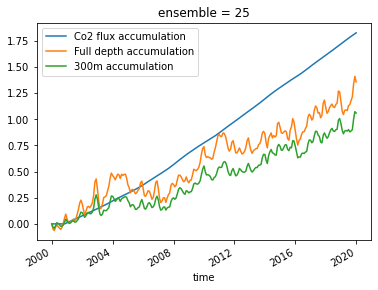

In [26]:
(co2.cumsum()/12).plot()
(((anth_c_area-anth_c_area.values[0]).sum(['lat','lon','st_ocean'])*12)/1e18).plot()
(((anth_c_area-anth_c_area.values[0]).sel(st_ocean=slice(0,300)).sum(['lat','lon','st_ocean'])*12)/1e18).plot()
plt.legend(['Co2 flux accumulation','Full depth accumulation','300m accumulation'])

In [37]:
co2.mean().values

array(0.09531659, dtype=float32)

In [83]:
# Accumulation per year
(((anth_c_area-anth_c_area.values[0]).sum(['lat','lon','st_ocean'])*12)/1e18).mean()/20

<xarray.DataArray ()>
array(0.02972594)
Coordinates:
    ensemble  int32 25

In [86]:
# Accumulation per year in surface 300
(((anth_c_area-anth_c_area.values[0]).sel(st_ocean=slice(0,300)).sum(['lat','lon','st_ocean'])*12)/1e18).mean()/20

<xarray.DataArray ()>
array(0.0215739)
Coordinates:
    ensemble  int32 25

In [12]:
# Ok Now lets sort out our transports

In [14]:
# N and S transport faces
ty_transport=phys_eqpac[['ty_trans','ty_trans_gm']].sel(ensemble=25,time=slice('2000-01-01','2020-01-01'),lon=slice(120,300)).sel(lat_x=[-5,-3,3,5],method='nearest')
ty_transport=ty_transport.rename({'lat_x':'lat'})
ty_transport_loaded=ty_transport.load()

In [75]:
# E Boundary.
tx_transport=phys_eqpac[['tx_trans','tx_trans_gm']].sel(ensemble=25,time=slice('2000-01-01','2020-01-01'),lat=slice(-5,5)).sel(lon_x=120,method='nearest')
#tx_transport=ty_transport.rename({'lon_x':'lon'})
tx_transport_loaded=tx_transport.load()

In [76]:
ty_transport_loaded

<xarray.Dataset>
Dimensions:      (time: 241, st_ocean: 50, lat: 4, lon: 170)
Coordinates:
    ensemble     int32 25
  * st_ocean     (st_ocean) float64 5.0 15.0 25.0 ... 5.499e+03 5.831e+03
  * time         (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2020-01-01
  * lon          (lon) float64 120.5 121.5 122.5 123.5 ... 287.5 288.5 289.5
  * lat          (lat) float64 -5.0 -3.0 3.0 5.0
Data variables:
    ty_trans     (time, st_ocean, lat, lon) float32 0.03704 0.03704 ... nan nan
    ty_trans_gm  (time, st_ocean, lat, lon) float32 0.0 0.0 nan ... nan nan nan
Attributes: (12/24)
    calendar:                 julian
    cm-enkf_source:          commit 0141830a243704acbf6d8c8c843b161a39ec39fa
    contact_name:            Decadal Activity 1 - Data Assimilation
    control_name:            c5
    creation_date:           Thu Nov  5 17:19:53 2020
    data_assimilation_name:  d60
    ...                      ...
    model_source:            commit 2abb29f4384e68777721fa657850587f28efd85a
    nominal_resoltuion:      Atmosphere delta lat = 2.02degrees ; Atmosphere ...
    perturbation_name:       not applicable
    references:              OKane, T.J., Sandery, P.A., Monselesan, D.P., Sa...
    run_variant_name:        data assimilation
    title:                   AccessOcean-AM2

In [77]:
raw_carbon

<xarray.Dataset>
Dimensions:   (time: 241, st_ocean: 50, lat: 30, lon: 170)
Coordinates:
    ensemble  int32 25
  * st_ocean  (st_ocean) float64 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03
  * time      (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2020-01-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -4.833 -4.5 -4.166 -3.834 ... 3.834 4.166 4.5 4.833
Data variables:
    dic       (time, st_ocean, lat, lon) float32 1.748e+03 1.75e+03 ... nan nan
    adic      (time, st_ocean, lat, lon) float32 1.796e+03 1.799e+03 ... nan nan
Attributes: (12/24)
    calendar:                 julian
    cm-enkf_source:          commit 0141830a243704acbf6d8c8c843b161a39ec39fa
    contact_name:            Decadal Activity 1 - Data Assimilation
    control_name:            c5
    creation_date:           Thu Nov  5 17:19:53 2020
    data_assimilation_name:  d60
    ...                      ...
    model_source:            commit 2abb29f4384e68777721fa657850587f28efd85a
    nominal_resoltuion:      Atmosphere delta lat = 2.02degrees ; Atmosphere ...
    perturbation_name:       not applicable
    references:              OKane, T.J., Sandery, P.A., Monselesan, D.P., Sa...
    run_variant_name:        data assimilation
    title:                   AccessOcean-AM2

In [78]:
ty_transport_loaded

<xarray.Dataset>
Dimensions:      (time: 241, st_ocean: 50, lat: 4, lon: 170)
Coordinates:
    ensemble     int32 25
  * st_ocean     (st_ocean) float64 5.0 15.0 25.0 ... 5.499e+03 5.831e+03
  * time         (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2020-01-01
  * lon          (lon) float64 120.5 121.5 122.5 123.5 ... 287.5 288.5 289.5
  * lat          (lat) float64 -5.0 -3.0 3.0 5.0
Data variables:
    ty_trans     (time, st_ocean, lat, lon) float32 0.03704 0.03704 ... nan nan
    ty_trans_gm  (time, st_ocean, lat, lon) float32 0.0 0.0 nan ... nan nan nan
Attributes: (12/24)
    calendar:                 julian
    cm-enkf_source:          commit 0141830a243704acbf6d8c8c843b161a39ec39fa
    contact_name:            Decadal Activity 1 - Data Assimilation
    control_name:            c5
    creation_date:           Thu Nov  5 17:19:53 2020
    data_assimilation_name:  d60
    ...                      ...
    model_source:            commit 2abb29f4384e68777721fa657850587f28efd85a
    nominal_resoltuion:      Atmosphere delta lat = 2.02degrees ; Atmosphere ...
    perturbation_name:       not applicable
    references:              OKane, T.J., Sandery, P.A., Monselesan, D.P., Sa...
    run_variant_name:        data assimilation
    title:                   AccessOcean-AM2

In [79]:
adic_concentrations

<xarray.DataArray (time: 241, st_ocean: 50, lat: 30, lon: 170)>
array([[[[48.557373, 48.423462,       nan, ...,       nan,       nan,
                nan],
         [47.903564, 47.770874,       nan, ...,       nan,       nan,
                nan],
         [47.366455, 47.277588,       nan, ...,       nan,       nan,
                nan],
         ...,
         [48.2782  , 48.496704, 48.572754, ...,       nan,       nan,
                nan],
         [48.758057, 48.817505, 48.747925, ...,       nan,       nan,
                nan],
         [49.142212, 49.101562, 48.904785, ...,       nan,       nan,
                nan]],

        [[48.561157, 48.425903,       nan, ...,       nan,       nan,
                nan],
         [47.90808 , 47.77234 ,       nan, ...,       nan,       nan,
                nan],
         [47.36853 , 47.27893 ,       nan, ...,       nan,       nan,
                nan],
...
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan]],

        [[      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         ...,
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan]]]], dtype=float32)
Coordinates:
    ensemble  int32 25
  * st_ocean  (st_ocean) float64 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03
  * time      (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2020-01-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -4.833 -4.5 -4.166 -3.834 ... 3.834 4.166 4.5 4.833

<xarray.DataArray 'tx_trans' (time: 241, st_ocean: 50, lat: 30)>
array([[[        nan,         nan,         nan, ..., -0.00349168,
         -0.00728335, -0.01059127],
        [        nan,         nan,         nan, ...,  0.00147999,
         -0.00136671, -0.0033013 ],
        [        nan,         nan,         nan, ..., -0.00100611,
         -0.00328473, -0.00351117],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ..., -0.02173378,
         -0.02089603, -0.02196396],
        [        nan,         nan,         nan, ..., -0.01529342,
         -0.01259447, -0.0113884 ],
        [        nan,         nan,         nan, ..., -0.01465122,
         -0.01029343, -0.00690386],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ..., -0.0289429 ,
         -0.02806057, -0.02529899],
        [        nan,         nan,         nan, ..., -0.0169338 ,
         -0.01648758, -0.01351429],
        [        nan,         nan,         nan, ..., -0.00918115,
         -0.00963643, -0.00676078],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]], dtype=float32)
Coordinates:
    ensemble  int32 25
  * st_ocean  (st_ocean) float64 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03
  * time      (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2020-01-01
    lon_x     float64 120.0
  * lat       (lat) float64 -4.833 -4.5 -4.166 -3.834 ... 3.834 4.166 4.5 4.833
Attributes:
    cell_methods:   time: mean
    long_name:      T-cell i-mass transport
    standard_name:  ocean_x_mass_transport
    units:          Sv (10^9 kg/s)
    valid_range:    [-1.0000000200408773e+20, 1.0000000200408773e+20]

In [53]:
adic_concentrations=raw_carbon.adic-raw_carbon.dic

In [125]:
S_face_tx=ty_transport_loaded.ty_trans.sel(lat=-5,method='nearest')*adic_concentrations.sel(lat=-5,method='nearest').interp(lon=ty_transport_loaded.lon)
S_face_tx_3=ty_transport_loaded.ty_trans.sel(lat=-3,method='nearest')*adic_concentrations.sel(lat=-3,method='nearest').interp(lon=ty_transport_loaded.lon)

S_face_tx_gm=ty_transport_loaded.ty_trans_gm.sel(lat=-5,method='nearest')*adic_concentrations.sel(lat=-5,method='nearest').interp(lon=ty_transport_loaded.lon)
S_face_tx_3_gm=ty_transport_loaded.ty_trans_gm.sel(lat=-3,method='nearest')*adic_concentrations.sel(lat=-3,method='nearest').interp(lon=ty_transport_loaded.lon)

In [175]:
N_face_tx=ty_transport_loaded.ty_trans.sel(lat=5,method='nearest')*adic_concentrations.sel(lat=5,method='nearest').interp(lon=ty_transport_loaded.lon)
N_face_tx_3=ty_transport_loaded.ty_trans.sel(lat=3,method='nearest')*adic_concentrations.sel(lat=3,method='nearest').interp(lon=ty_transport_loaded.lon)

N_face_tx_gm=ty_transport_loaded.ty_trans_gm.sel(lat=5,method='nearest')*adic_concentrations.sel(lat=-5,method='nearest').interp(lon=ty_transport_loaded.lon)
N_face_tx_3_gm=ty_transport_loaded.ty_trans_gm.sel(lat=3,method='nearest')*adic_concentrations.sel(lat=3,method='nearest').interp(lon=ty_transport_loaded.lon)

In [173]:
E_face_tx=tx_transport_loaded.tx_trans.sel(lat=5,method='nearest')*adic_concentrations.sel(lon=120,method='nearest').interp(lat=tx_transport_loaded.lat)
E_face_tx_gm=tx_transport_loaded.tx_trans_gm.sel(lat=5,method='nearest')*adic_concentrations.sel(lon=120,method='nearest').interp(lat=tx_transport_loaded.lat)


In [126]:
((S_face_tx.sum(['lon','st_ocean'])*12*60*60*24*365*1e6)/1e18).mean(dim='time')

<xarray.DataArray ()>
array(0.15031024)
Coordinates:
    ensemble  int32 25

In [127]:
((S_face_tx.sel(st_ocean=slice(0,300)).sum(['lon','st_ocean'])*12*60*60*24*365*1e6)/1e18).mean(dim='time')

<xarray.DataArray ()>
array(0.04842566)
Coordinates:
    ensemble  int32 25

In [128]:
((S_face_tx_3.mean(dim='time').sum(['lon','st_ocean'])*12*60*60*24*365*1e6)/1e18)

<xarray.DataArray ()>
array(0.22111664)
Coordinates:
    ensemble  int32 25

In [129]:
((S_face_tx_3.sum(['lon','st_ocean'])*12*60*60*24*365*1e6)/1e18).mean(dim='time')

<xarray.DataArray ()>
array(0.22111664)
Coordinates:
    ensemble  int32 25

In [130]:
((S_face_tx_3.sel(st_ocean=slice(0,300)).mean(dim='time').sum(['lon','st_ocean'])*12*60*60*24*365*1e6)/1e18)

<xarray.DataArray ()>
array(0.13595137)
Coordinates:
    ensemble  int32 25

In [131]:
((S_face_tx_3.mean(dim='time').sum(['lon','st_ocean'])*12*60*60*24*365*1e6)/1e18)

<xarray.DataArray ()>
array(0.22111664)
Coordinates:
    ensemble  int32 25

In [132]:
((N_face_tx.sel(st_ocean=slice(0,300)).mean(dim='time').sum(['lon','st_ocean'])*12*60*60*24*365*1e6)/1e18)

<xarray.DataArray ()>
array(0.2131259)
Coordinates:
    ensemble  int32 25

In [133]:
((N_face_tx.mean(dim='time').sum(['lon','st_ocean'])*12*60*60*24*365*1e6)/1e18)

<xarray.DataArray ()>
array(0.18205968)
Coordinates:
    ensemble  int32 25

In [134]:
((N_face_tx_3.sel(st_ocean=slice(0,300)).mean(dim='time').sum(['lon','st_ocean'])*12*60*60*24*365*1e6)/1e18)

<xarray.DataArray ()>
array(0.24979286)
Coordinates:
    ensemble  int32 25

In [135]:
((N_face_tx_3.mean(dim='time').sum(['lon','st_ocean'])*12*60*60*24*365*1e6)/1e18)

In [193]:
N_face_tx

<xarray.DataArray (time: 241, st_ocean: 50, lon: 170)>
array([[[ -0.3443896 ,   2.94132502,   4.68025988, ...,          nan,
                  nan,          nan],
        [  0.07545199,   3.34934566,   5.09791417, ...,          nan,
                  nan,          nan],
        [  0.62736637,   3.37938099,   4.95935962, ...,          nan,
                  nan,          nan],
        ...,
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]],

       [[ 10.13367328,   5.27749584,   1.95661967, ...,          nan,
                  nan,          nan],
        [ 10.57115105,   5.71942896,   2.39327882, ...,          nan,
                  nan,          nan],
        [ 10.45149691,   5.75015022,   2.29209952, ...,          nan,
                  nan,          nan],
...
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]],

       [[ -1.61970023,   2.83463092,   5.52039458, ...,          nan,
                  nan,          nan],
        [ -0.72202033,   3.77160351,   6.56806545, ...,          nan,
                  nan,          nan],
        [ -0.61863794,   3.88414365,   6.7828533 , ...,          nan,
                  nan,          nan],
        ...,
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]]])
Coordinates:
    ensemble  int32 25
  * st_ocean  (st_ocean) float64 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03
  * time      (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2020-01-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5

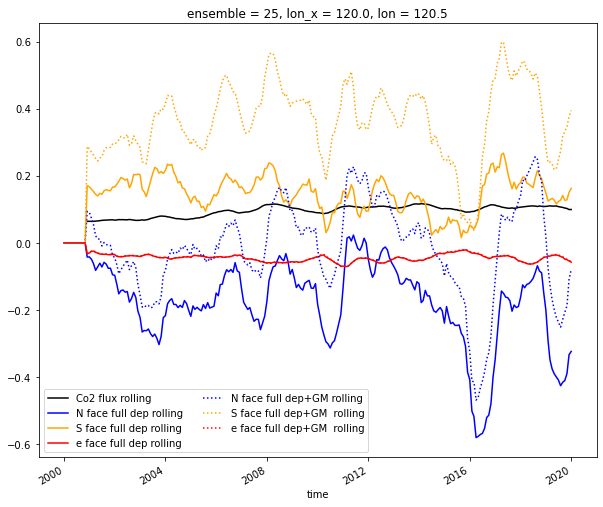

In [215]:
plt.figure(figsize=(10,8))
(co2.rolling(time=12).mean().plot(c='k'))
(((-N_face_tx.rolling(time=12).mean().sum(['lon','st_ocean']))*12*60*60*24*365*1e6)/1e18).plot(c='b')
(((S_face_tx.rolling(time=12).mean().sum(['lon','st_ocean']))*12*60*60*24*365*1e6)/1e18).plot(c='orange')
(((E_face_tx.rolling(time=12).mean().sum(['lat','st_ocean']))*12*60*60*24*365*1e6)/1e18).plot(c='red')

(((-(N_face_tx+N_face_tx_gm).rolling(time=12).mean().sum(['lon','st_ocean']))*12*60*60*24*365*1e6)/1e18).plot(c='b',linestyle=":")
((((S_face_tx+S_face_tx_gm).rolling(time=12).mean().sum(['lon','st_ocean']))*12*60*60*24*365*1e6)/1e18).plot(c='orange',linestyle=":")
((((E_face_tx+E_face_tx_gm).rolling(time=12).mean().sum(['lat','st_ocean']))*12*60*60*24*365*1e6)/1e18).plot(c='red',linestyle=":")
plt.legend(['Co2 flux rolling','N face full dep rolling','S face full dep rolling','e face full dep rolling','N face full dep+GM rolling','S face full dep+GM  rolling','e face full dep+GM  rolling'],ncol=2)

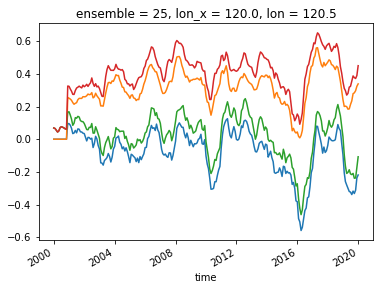

In [213]:
(((((-N_face_tx.rolling(time=12).mean().sum(['lon','st_ocean']))*12*60*60*24*365*1e6)/1e18)+((S_face_tx.rolling(time=12).mean().sum(['lon','st_ocean']))*12*60*60*24*365*1e6)/1e18)+(((E_face_tx.rolling(time=12).mean().sum(['lat','st_ocean']))*12*60*60*24*365*1e6)/1e18)).plot()
((((((-(N_face_tx+N_face_tx_gm).rolling(time=12).mean().sum(['lon','st_ocean']))*12*60*60*24*365*1e6)/1e18)+((S_face_tx+S_face_tx_gm).rolling(time=12).mean().sum(['lon','st_ocean']))*12*60*60*24*365*1e6)/1e18)+((((E_face_tx+E_face_tx_gm).rolling(time=12).mean().sum(['lat','st_ocean']))*12*60*60*24*365*1e6)/1e18)).plot()




(((((-N_face_tx.rolling(time=12).mean().sum(['lon','st_ocean']))*12*60*60*24*365*1e6)/1e18)+((S_face_tx.rolling(time=12).mean().sum(['lon','st_ocean']))*12*60*60*24*365*1e6)/1e18)+(((E_face_tx.rolling(time=12).mean().sum(['lat','st_ocean']))*12*60*60*24*365*1e6)/1e18)+co2).plot()
((((((-(N_face_tx+N_face_tx_gm).rolling(time=12).mean().sum(['lon','st_ocean']))*12*60*60*24*365*1e6)/1e18)+((S_face_tx+S_face_tx_gm).rolling(time=12).mean().sum(['lon','st_ocean']))*12*60*60*24*365*1e6)/1e18)+((((E_face_tx+E_face_tx_gm).rolling(time=12).mean().sum(['lat','st_ocean']))*12*60*60*24*365*1e6)/1e18)+co2).plot()

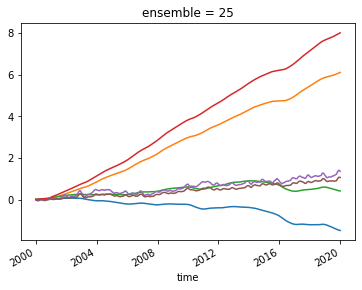

In [214]:
((((((-N_face_tx.rolling(time=12).mean().sum(['lon','st_ocean']))*12*60*60*24*365*1e6)/1e18)+((S_face_tx.rolling(time=12).mean().sum(['lon','st_ocean']))*12*60*60*24*365*1e6)/1e18)+(((E_face_tx.rolling(time=12).mean().sum(['lat','st_ocean']))*12*60*60*24*365*1e6)/1e18)).cumsum()/12).plot()
(((((((-(N_face_tx+N_face_tx_gm).rolling(time=12).mean().sum(['lon','st_ocean']))*12*60*60*24*365*1e6)/1e18)+((S_face_tx+S_face_tx_gm).rolling(time=12).mean().sum(['lon','st_ocean']))*12*60*60*24*365*1e6)/1e18)+((((E_face_tx+E_face_tx_gm).rolling(time=12).mean().sum(['lat','st_ocean']))*12*60*60*24*365*1e6)/1e18)).cumsum()/12).plot()

((((((-N_face_tx.rolling(time=12).mean().sum(['lon','st_ocean']))*12*60*60*24*365*1e6)/1e18)+((S_face_tx.rolling(time=12).mean().sum(['lon','st_ocean']))*12*60*60*24*365*1e6)/1e18)+(((E_face_tx.rolling(time=12).mean().sum(['lat','st_ocean']))*12*60*60*24*365*1e6)/1e18)+co2).cumsum()/12).plot()
(((((((-(N_face_tx+N_face_tx_gm).rolling(time=12).mean().sum(['lon','st_ocean']))*12*60*60*24*365*1e6)/1e18)+((S_face_tx+S_face_tx_gm).rolling(time=12).mean().sum(['lon','st_ocean']))*12*60*60*24*365*1e6)/1e18)+((((E_face_tx+E_face_tx_gm).rolling(time=12).mean().sum(['lat','st_ocean']))*12*60*60*24*365*1e6)/1e18)+co2).cumsum()/12).plot()


(((anth_c_area-anth_c_area.values[0]).sum(['lat','lon','st_ocean'])*12)/1e18).plot()
(((anth_c_area-anth_c_area.values[0]).sel(st_ocean=slice(0,300)).sum(['lat','lon','st_ocean'])*12)/1e18).plot()







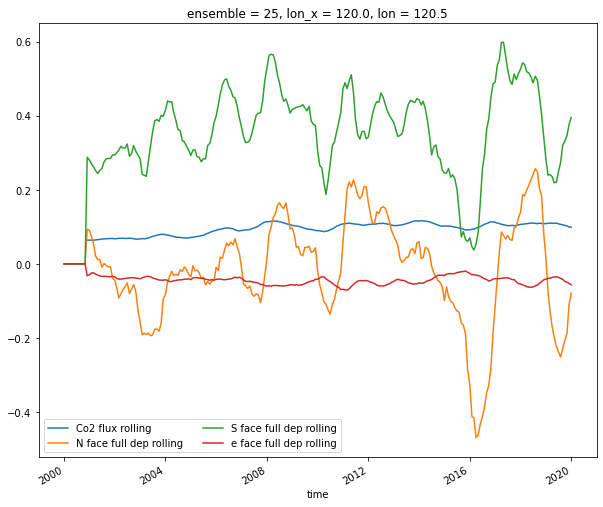

In [197]:
plt.figure(figsize=(10,8))

plt.legend(['Co2 flux rolling','N face full dep rolling','S face full dep rolling','e face full dep rolling'],ncol=2)

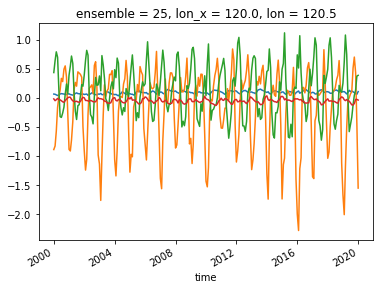

In [191]:
(co2.plot())
(((-N_face_tx.sum(['lon','st_ocean']))*12*60*60*24*365*1e6)/1e18).plot()
(((S_face_tx.sum(['lon','st_ocean']))*12*60*60*24*365*1e6)/1e18).plot()
(((E_face_tx.sum(['lat','st_ocean']))*12*60*60*24*365*1e6)/1e18).plot()

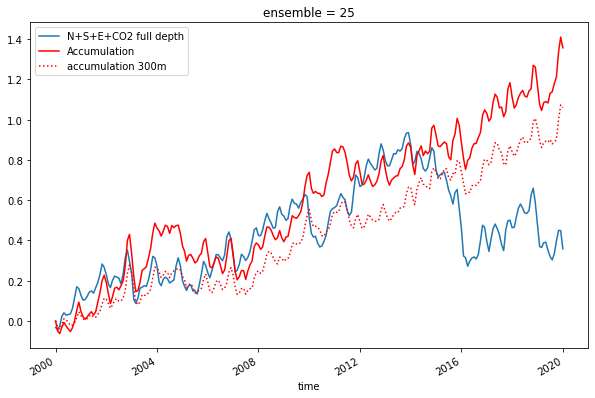

In [227]:
plt.figure(figsize=(10,6))
(((((-N_face_tx.sum(['lon','st_ocean'])+S_face_tx.sum(['lon','st_ocean'])+E_face_tx.sum(['lat','st_ocean']))*12*60*60*24*365*1e6)/1e18)+co2).cumsum()/12).plot()
#(((((-(N_face_tx+N_face_tx_gm).sum(['lon','st_ocean'])+(S_face_tx+S_face_tx_gm).sum(['lon','st_ocean'])+(E_face_tx+E_face_tx_gm).sum(['lat','st_ocean']))*12*60*60*24*365*1e6)/1e18)+co2).cumsum()/12).plot()
#(((((-N_face_tx.sel(st_ocean=slice(0,300)).sum(['lon','st_ocean'])+S_face_tx.sel(st_ocean=slice(0,300)).sum(['lon','st_ocean'])+E_face_tx.sel(st_ocean=slice(0,300)).sum(['lat','st_ocean']))*12*60*60*24*365*1e6)/1e18)+co2).cumsum()/12).plot()
#(((((-(N_face_tx+N_face_tx_gm).sel(st_ocean=slice(0,300)).sum(['lon','st_ocean'])+(S_face_tx+S_face_tx_gm).sel(st_ocean=slice(0,300)).sum(['lon','st_ocean'])+(E_face_tx+E_face_tx_gm).sel(st_ocean=slice(0,300)).sum(['lat','st_ocean']))*12*60*60*24*365*1e6)/1e18)+co2).cumsum()/12).plot()

#((((-N_face_tx.sum(['lon','st_ocean'])+S_face_tx.sum(['lon','st_ocean'])+E_face_tx.sum(['lat','st_ocean']))*12*60*60*24*365*1e6)/1e18).cumsum()/12).plot()
(((anth_c_area-anth_c_area.values[0]).sum(['lat','lon','st_ocean'])*12)/1e18).plot(c='r')
(((anth_c_area-anth_c_area.values[0]).sel(st_ocean=slice(0,300)).sum(['lat','lon','st_ocean'])*12)/1e18).plot(c='r',linestyle=':')
plt.legend(['N+S+E+CO2 full depth','Accumulation', 'accumulation 300m'])
#plt.legend(['N+S+E+CO2','N_gm+S_gm+E_gm+CO2','N+S+E+CO2 300m','N_gm+S_gm+E_gm+CO2 300m','Accumulation','Accumulation 300m'],ncol=3)

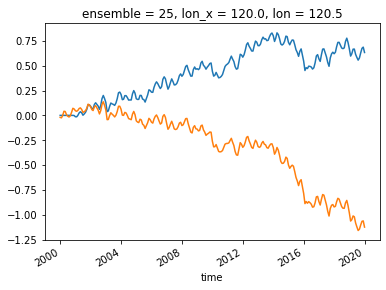

In [167]:
(((((-N_face_tx_3.sum(['lon','st_ocean'])+S_face_tx_3.sum(['lon','st_ocean'])+E_face_tx.sum(['lat','st_ocean']))*12*60*60*24*365*1e6)/1e18)+co2).cumsum()/12).plot()
((((-N_face_tx_3.sum(['lon','st_ocean'])+S_face_tx_3.sum(['lon','st_ocean'])+E_face_tx.sum(['lat','st_ocean']))*12*60*60*24*365*1e6)/1e18).cumsum()/12).plot()

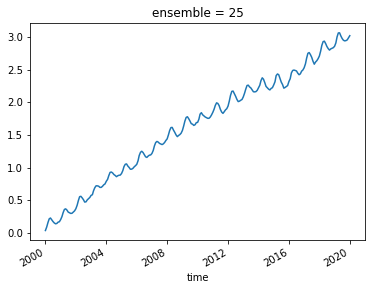

In [153]:
(((S_face_tx.sum(['lon','st_ocean'])*12*60*60*24*365*1e6)/1e18).cumsum()/12).plot()

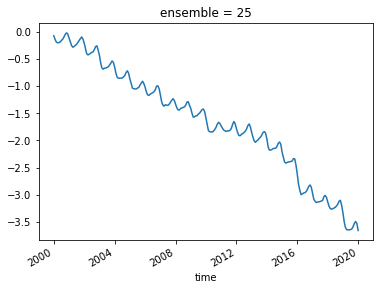

In [154]:
(((-N_face_tx.sum(['lon','st_ocean'])*12*60*60*24*365*1e6)/1e18).cumsum()/12).plot()

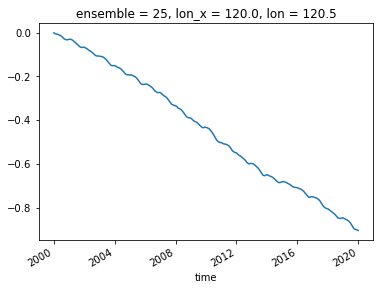

In [155]:
(((E_face_tx.sum(['lat','st_ocean'])*12*60*60*24*365*1e6)/1e18).cumsum()/12).plot()

In [ ]:
# Old Transports.
cafe_y_tx=xr.open_dataset(f'../processed_data/physics_ds/ty_trans_physics_feb7.nc').ty_trans.chunk('auto')
cafe_x_tx=xr.open_dataset(f'../processed_data/physics_ds/tx_trans_physics_feb7.nc').tx_trans.chunk('auto')
anth_dic_cafe=xr.open_dataset('../processed_data/physics_ds/anth_DIC_pac_feb7.nc')
dic_cafe=xr.open_dataset('../processed_data/physics_ds/dic_pac_feb7.nc')


cafe_y_tx_fulldep=xr.open_dataset(f'../processed_data/physics_ds/ty_trans_fulldep_physics_feb7.nc').ty_trans.chunk('auto')
cafe_y_tx_fulldep_gm=xr.open_dataset(f'../processed_data/physics_ds/ty_trans_gm_fulldep_physics_feb7.nc').ty_trans_gm.chunk('auto')

cafe_x_tx_fulldep=xr.open_dataset(f'../processed_data/physics_ds/tx_trans_fulldep_physics_feb7.nc').tx_trans.chunk('auto')
cafe_x_tx_fulldep_gm=xr.open_dataset(f'../processed_data/physics_ds/tx_trans_gm_fulldep_physics_feb7.nc').tx_trans_gm.chunk('auto')